In [1]:
!gdown --id 1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1
!gdown --id 1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI
!gdown --id 1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb

Downloading...
From: https://drive.google.com/uc?id=1E-voIV2ctU4Brw022Na8RHVVRGOoNkO1
To: /content/data.txt
100% 703k/703k [00:00<00:00, 82.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yXNlZWMqUcAwDScBrkFChOHJwR1FZXmI
To: /content/c1.txt
100% 1.69k/1.69k [00:00<00:00, 1.44MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vfovle9DgaeK0LnbQTH0j7kRaJjsvLtb
To: /content/c2.txt
100% 1.84k/1.84k [00:00<00:00, 2.79MB/s]


In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

     |████████████████████████████████| 212.4MB 68kB/s 
     |████████████████████████████████| 204kB 18.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=04cd604e2e1ace98a9fb510693465734fd6a52ab5b867ea29d009ff413553587
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading

In [3]:
import itertools
from pyspark import SparkContext, SparkConf
from pyspark.sql import *
#from pyspark.sql.functions import * it overrides abs if we do it like that
import re, sys, pickle
from functools import reduce
import pyspark.sql.functions as F
import matplotlib.pyplot as pl

In [4]:
# create the Spark Session
spark = SparkSession.builder.getOrCreate()

# create the Spark Context
sc = spark.sparkContext

In [5]:
#Euclidian
def l22(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + b * b, delta, 0)
#Manhattan
def l1(u, v):
    delta = [u[i] - v[i] for i in range(len(u))]
    return reduce(lambda a, b: a + abs(b), delta, 0)

def findCentroid(pt, cens, distFcn, phi):
    best = float('inf')
    besti = None
    for i, cen in enumerate(cens.value):
        cand = distFcn(pt, cen)
        if cand < best:
            best = cand
            besti = i
    phi += best
    return besti, pt

def aggregate_UV(cumulative, pt):
    cumulative_pt, cumulative_cnt = cumulative
    for i in range(len(pt)):
        cumulative_pt[i] += pt[i]
    return cumulative_pt, cumulative_cnt + 1

def aggregate_UU(a, b):
    a_pt, a_cnt = a
    b_pt, b_cnt = b
    for i in range(len(a_pt)):
        a_pt[i] += b_pt[i]
    return a_pt, a_cnt + b_cnt

In [10]:
#We need to make each and every combination (c1 - l1, c1 -l22, c2 - l1 and c2 - l22)
#we need to comment and uncomment which one we wan't to use

dataFile = '/content/data.txt'
# censFile = '/content/c1.txt' 
censFile = '/content/c2.txt'
distFcn = l1 #Manhattan
# distFcn = l22 #Euclidian
# outFile = 'Euclidian_c1.txt'
# outFile = 'Euclidian_c2.txt'
# outFile = 'Manhattan_c1.txt'
outFile = 'Manhattan_c2.txt'


MAX_ITER = 20 #max iterations
k = 10 #clusters
NDATA = 4601
NDIM = 58
cens = []


# init centroids
cens = []
with open(censFile) as fh:
    for line in fh:
        if not line:
            continue
        cens.append(list(map(float, line.split())))

cens = sc.broadcast(cens)

# load data
data = sc.textFile( dataFile)
data = data.map(lambda l: list(map(float, l.split())))

phi = sc.accumulator(0)
totCosts = []

for it in range(1, MAX_ITER + 1):
    print('\n' * 6 + 'iteration %d' % it + '\n' * 6)

    i_pt = data.map(lambda pt: findCentroid(pt, cens, distFcn, phi))
    
    #calc new centroid
    i_sumCoors_cnt = i_pt.aggregateByKey(([0] * NDIM, 0),
                                         aggregate_UV, aggregate_UU)
    i_sumCoors_cnt = i_sumCoors_cnt.collect()
    newCens = [None] * k
    for i, sumCoors_cnt in i_sumCoors_cnt:
        sumCoors, cnt = sumCoors_cnt
        newCens[i] = [sumCoors[j] / cnt for j in range(len(sumCoors))]
    assert not any([cen is None for cen in newCens])

    # record cost, prep new iter
    totCosts.append(phi.value)
    phi.value = 0
    cens.unpersist()
    cens = sc.broadcast(newCens)

print('\n' * 6 + '%f\n' * MAX_ITER % tuple(totCosts) + '\n' * 6 )
with open(outFile, 'wb') as fh:
    pickle.dump(totCosts, fh)







iteration 1












iteration 2












iteration 3












iteration 4












iteration 5












iteration 6












iteration 7












iteration 8












iteration 9












iteration 10












iteration 11












iteration 12












iteration 13












iteration 14












iteration 15












iteration 16












iteration 17












iteration 18












iteration 19












iteration 20












1433739.310000
1084488.776965
973431.714662
895934.592563
865128.335294
845846.647031
827219.582756
803590.345601
756039.517276
717332.902543
694587.925253
684444.501997
674574.747548
667409.469916
663556.627822
660162.777229
656041.322295
653036.754073
651112.426252
649689.013184









Euclidian c1 0.2648391714456053
Euclidian c2 0.7669795594605946
Manhattan c1 0.18654709691385904
Manhattan c2 0.515540991023891


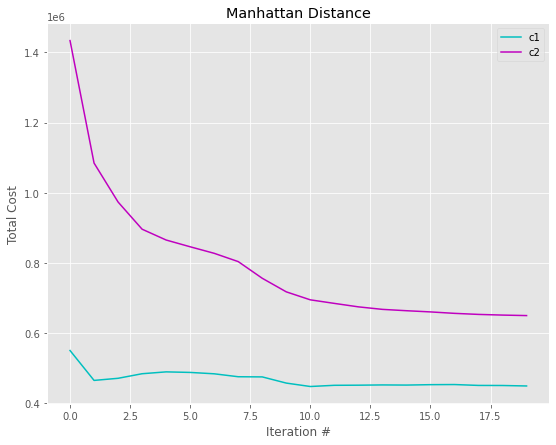

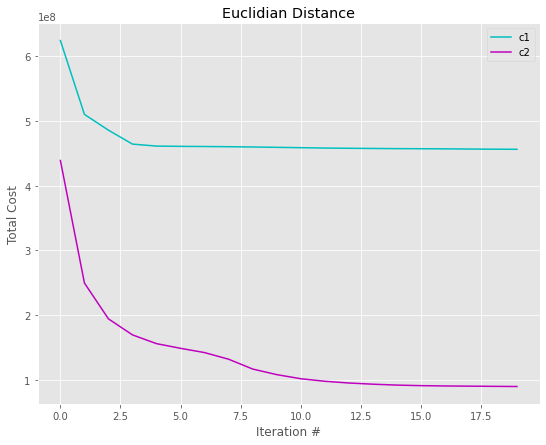

In [11]:
from matplotlib import style
style.use('ggplot')

pl.close('all')
with open('Manhattan_c1.txt', 'rb') as fh:
    l1c1 = pickle.load(fh)
with open('Manhattan_c2.txt', 'rb') as fh:
    l1c2 = pickle.load(fh)
with open('Euclidian_c1.txt', 'rb') as fh:
    l22c1 = pickle.load(fh)
with open('Euclidian_c2.txt', 'rb') as fh:
    l22c2 = pickle.load(fh)

pl.figure(figsize=(9, 7))
pl.title("Manhattan Distance")
pl.plot(l1c1, label='c1',color='c')
pl.plot(l1c2, label='c2',color='m')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotManhattan.png', dpi=300, bbox_inches='tight')

pl.figure(figsize=(9, 7))
pl.title("Euclidian Distance")
pl.plot(l22c1, label='c1',color='c')
pl.plot(l22c2, label='c2',color='m')
pl.xlabel("Iteration #")
pl.ylabel("Total Cost")
pl.legend()
pl.savefig('plotEuclidian.png', dpi=300, bbox_inches='tight')

def change(L):
    return (L[0] - L[10]) / L[0]

print('Euclidian c1', change(l22c1))
print('Euclidian c2', change(l22c2))
print('Manhattan c1', change(l1c1))
print('Manhattan c2', change(l1c2))